In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import UnivariateSpline
from __future__ import print_function
from past.builtins import xrange 
from future.utils import iteritems 
from scipy import sparse, optimize
from scipy.sparse import linalg as spla
from scipy import linalg as la 
from scipy.linalg import LinAlgError
from scipy.interpolate import PPoly
import sys
import seaborn as sns

In [2]:
spot=pd.read_csv('long-term-spx-vix.csv')
#spot=spot.set_index(spot.columns[0])
spot.head()
training_data=spot.dropna()
training_data=training_data.reset_index(drop=True)
training_data=training_data.set_index(training_data.columns[0])
training_data=training_data.interpolate(method='time')
training_data.head()

,SPX INDEX,VIX INDEX
EffectiveDate,,
1990-01-02,359.69,17.24
1990-01-03,358.76,18.19
1990-01-04,355.67,19.22
1990-01-05,352.20,20.11
1990-01-08,353.79,20.26


In [3]:
spot=pd.read_csv('long-term-spx-vix.csv')
v = spot['SPX INDEX']
SPX_realvol = np.log(v/v.shift()).rolling(22).std() * np.sqrt(260)
spot['Realised vol']=SPX_realvol
VIX_INDEX = spot['VIX INDEX'] * 1e-2
train=spot
train['VIX INDEX']=train['VIX INDEX'] * 1e-2
train=train.dropna()
train.head()

,EffectiveDate,SPX INDEX,VIX INDEX,Realised vol
15551,1990-01-02,359.69,0.1724,0.121350
15552,1990-01-03,358.76,0.1819,0.121051
15553,1990-01-04,355.67,0.1922,0.118352
15554,1990-01-05,352.20,0.2011,0.123483
15555,1990-01-08,353.79,0.2026,0.122816


In [10]:
x=list(train['VIX INDEX'])
y=list(train['Realised vol'])


#sort x and corresponding y
x_set_id=[x.index(i) for i in set(x)]
x_set=[x[i] for i in x_set_id]
y_set=np.array([y[i] for i in x_set_id])
x_idx=list(np.argsort(x_set))
x_set=sorted(x_set)
y_set=list(y_set[x_idx])

In [6]:
class NaturalCubicSpline:
    def __init__(self, x=None, y=None, w=None, p='GCV', LOG=True, 
                                        #boundary_condition='natural',
                                        return_spline=True):
        """
        generate the (sparse) matrices R,Q and D
        y are the (noisy) data points parameterised by x
        w are the weights (possibly inverse squared relative uncertainty?)
        p is the smoothing criterion (or paramater)
        """
        if x is not None: 
            self.__take_inputs__(x, y, w, p, LOG)
        else:
            print( 'No data were provided')
            return

        if return_spline:
            f0, f2 = self.compute_smoothing_spline()
            #boundary_condition=boundary_condition)
            self.coefs = self.compute_coefficients(f0,f2) 

    def __take_inputs__(self, x, y, w, p, LOG):
        
        N = len(x) # Number of data points
        x, y = np.atleast_1d(x,y) # in case y in a list of y1,...,yd
        if y.ndim>1 and y.shape[1]>y.shape[0]:
            y = np.transpose(y)         
        self.w = w
        assert y.shape[0]==len(x), 'shape of y %s is not in accord with x %s' %\
                (y.shape, x.shape)
        self.x,self.y = x,y
        dx = np.diff(x)
        self.dx = dx
        # verify that x is in increasing order:
        assert np.all(dx>=0), 'x is not in increasing order'
        if w==None:
            self.D = 1
            self.D2 = 1
        else:
            self.D = sparse.diags(1./np.sqrt(w), 0, shape=(N,N))
            self.D2 = sparse.diags(1./w, 0, shape=(N,N))
        self.R = sparse.diags(
                    [2*(dx[:-1]+dx[1:]), dx[1:-1], dx[1:-1]],
                    [0,1,-1], 
                    shape=(N-2,N-2)
                    )
        self.Q = sparse.diags(
                    [1./dx[:-1], np.r_[-1./dx[:-1]-1./dx[1:],0], 1./dx[1:]],
                    # in the previous line the second diag is appended with
                    # and extra term (which will not be used), otherwise an
                    # error is raised
                    [0,1,2],
                    shape=(N-2,N) 
                    ).T
        
        try:
            if p in ['GCV', 'AIC', 'AICC', 'VM']:
                self.crit = p
                self.LOG = LOG # True => log of penatly terms instead of ratio
                self.p = self.parameter_selection()
            elif 0<=p<=1:
                self.p = p
            elif p<0:
                # In case p is not provided, attempt equal weight for the LSQ and
                # the penalty (Nir Krakauer's choice for octave-splines):
                #              Tr { 6(1-p) Q.T D^2 Q } = Tr { pR }
                R,Q,D2 = self.R, self.Q, self.D2
                lamda = R.diagonal().sum() / (Q.T * D2 * Q).diagonal().sum() / 6. 
                self.p = 1. / (1+lamda)
                self.crit = 'equal_traces'
        except:
            print( "Unexpected error:", sys.exc_info()[0])
            print( 'p=%s is not supported' % p)
            raise

    def compute_smoothing_spline(self, boundary_condition='natural'):
        y, Q, R, D2, p = self.y, self.Q, self.R, self.D2, self.p

        #assert p!=1 and p!=0, 'p=0 and p=1 are not implemented yet'
        # Solve for u: [ 6(1-p) Q.T D^2 Q + pR ] u = Q.T y
        Bp = 6*(1-p) * Q.T * D2 * Q + p*R
        b = Q.T*y

        Bp = Bp.todia()
        d = Bp.offsets[-1]
        u = la.solve_banded((d,d), Bp.data[::-1], b ) # needs inversion of order
        # get a = y - 6(1-p) D^2 Q u
        a = y - 6*(1-p)* D2 * Q * u

        # natural boundary conditions: 
        if boundary_condition=='natural':
            if len(u.shape)==1:
                f2 = np.pad(6*p*u,1,'constant', constant_values=0 )
            elif len(u.shape)==2:
                f2 = np.pad(6*p*u, ((1,1),(0,0)), 'constant', 
                                                    constant_values=0)

        f0 = a
        return f0, f2

    def compute_coefficients(self,f0,f2):
        """
        constructs the coefficients array where
            0th axis is for the intervals (defined by the knots)
            1st axis is the spline order (currently only cubic)
            2nd axis is for dimensionality
        [the equations are available in de Boor Chap. XIV Eqns 9]
        """
        order = 3
        if f0.ndim>1:
            n_intervals, ndim = f0.shape
        else: 
            ndim = 1
            n_intervals = f0.shape[0]
            f0 = f0[:, np.newaxis]
            f2 = f2[:, np.newaxis]
        coefs = np.empty((n_intervals ,order+1, ndim))
        dx = self.dx[:,np.newaxis]
        # initialise the first and last intervals coefs to zero
        coefs[[0,-1], ...] = 0 
        coefs[:, -1] = f0
        coefs[:, -3] = f2
        coefs[:-1, -4] = np.diff(f2,axis=0) / dx
        coefs[:-1, -2] = np.diff(f0,axis=0) / dx - dx/3. * (f2[:-1] + f2[1:]/2.)
        # last first derivative calculated by the last interval derivative:
        # f'(x_N) = f'(x_N-1) + f''(x_N-1) dx_N-1 + 1/2 f'''(x_N-1) dx_N-1**2
        coefs[-1, -2] = coefs[-2,-2] + \
                           coefs[-2,-3]*dx[-1] + \
                           coefs[-2,-4]*dx[-1]**2
        return coefs

#    def piecewise_polynomial(self):
#        piecewise_pol = [SP.PiecewisePolynomial(A.x, coefs.T[:,::-1], orders=3,
#            direction=1, axis=0) for coefs in A.coefs.T]
#        pass

    def get_ppoly_from_coefs(self, return_ppoly=False):
        self.ppoly = []

        for coefs in self.coefs.T: 
            _ppoly = coefs[:,:-1].copy()
            _ppoly[0] /= 6
            _ppoly[1] /= 2
            self.ppoly.append(PPoly(_ppoly, self.x, extrapolate=False))
        
        if len(self.ppoly)==1:
            self.ppoly = self.ppoly[0]

        if return_ppoly:
            return self.ppoly

    def Lambda(self,p):
        _Lambda = lambda p: self.S**2/(self.S**2 + p/(1-p)/6)
        try:
            return _Lambda(p)
        except AttributeError:
            self.U,self.S = self.svd_eye_minus_hat_matrix()
            return _Lambda(p)

    def estimate_uncertainty(self, p=None):
        if p is None:
            p = self.p
        Lambda = self.Lambda
        data_infidelity, trI_H = self.get_penalty_terms(p)
        ## estimated noise variance [`wahba83`]
        sigma2 = np.mean(data_infidelity) / trI_H
        ## standard error estimates of fitted values [`hutchinson86`]
        w = self.w if self.w!=None else 1
        diagH = 1 - np.dot(self.U**2, Lambda(p))
        unc_y = np.sqrt(sigma2 * diagH  / w)
        return sigma2, unc_y

    def parameter_selection(self):
        crit = self.crit.lower()
        #penalty_function = lambda p: penalty_compute(p, self.U, self.S**2,
        #                                             self.y, self.w,
        #                                             len(self.x))
        penalty_function = lambda p: getattr(self, crit)(p, self.LOG)
        p = optimize.fminbound(penalty_function, 0, 1)
        return p

    def svd_eye_minus_hat_matrix(self):
        """
        Following Craven & Wahba find the singular value decomposition of 
            F = D Q R^{-1/2} 
        This function returns the non-zero singular values S and the
        corresponding left singular vectors in U, satisfying
            I - Hp = D U [ si**2 / ( 6(1-p) si**2 + p ) ] U.T D**(-1)
        where si is the ith singular value.
        """
        method = 4
        if method==0:
            sqrt_invR = sqrtm(spla.inv(self.R).A)
        elif method==1:
            sqrt_invR = sqrtm(la.inv(self.R.todense()))
        elif method==2:
            invR = la.inv(self.R.todense())
            eR, oR = la.eigh(invR)
            sqrt_invR = oR.dot(np.diag(np.sqrt(eR))).dot(oR.T)
        elif method==3:
            eR, oR = la.eigh(self.R.todense())
            sqrt_invR = oR.dot(np.diag(1./np.sqrt(eR))).dot(oR.T)
        elif method==4:
            try:
                eR, oR = la.eig_banded(self.R.data[self.R.offsets>=0][::-1])
                sqrt_invR = oR.dot(np.diag(1./np.sqrt(eR))).dot(oR.T)
            except LinAlgError:
                # if eig_banded fails try the eigh
                eR, oR = la.eigh(self.R.todense())
                sqrt_invR = oR.dot(np.diag(1./np.sqrt(eR))).dot(oR.T)
        U, S, VT = la.svd(self.D * self.Q * sqrt_invR, full_matrices=False)
        return U,S
    
    def get_penalty_terms(self, p):
        
        Lambda = self.Lambda

        if self.w==None:
            L = Lambda(p)**2  
            z = (np.dot(self.U.T, self.y))**2 
            data_infidelity = L.dot(z)  
        else:
            ## || U Lambda U.T (sqrt(w)*y) ||**2
            sqrt_w = np.sqrt(self.w)
            L = Lambda(p)
            if self.y.ndim>1:
                sqrt_w = sqrt_w[:,np.newaxis]
                L = L[:,np.newaxis]
            y_weighted = sqrt_w * self.y
            z = L * self.U.T.dot(y_weighted) 
            data_infidelity = self.U.dot(z)
            data_infidelity = np.sum(data_infidelity**2,0)

        trace_eye_minus_hat = Lambda(p).sum()
        return data_infidelity, trace_eye_minus_hat
        
    def gcv(self, p, LOG=True):
        data_infidelity, trI_H = self.get_penalty_terms(p)
        if LOG:
            return np.mean(np.log(data_infidelity)) - \
                                                2*np.log(trI_H)
        else:
            return np.mean(data_infidelity) / trI_H**2

    def aic(self, p, LOG=True):
        data_infidelity, trI_H = self.get_penalty_terms(p)
        N = len(self.x)
        Y = 2*(N-trI_H)/N
        if LOG:
            return np.mean(np.log(data_infidelity)) + Y
                                                
        else:
            return np.mean(data_infidelity) * np.exp(Y)

    def aicc(self, p, LOG=True):
        data_infidelity, trI_H = self.get_penalty_terms(p)
        N = len(self.x)
        Y = (N-trI_H+1) / (trI_H/2 - 1) if trI_H/2 - 1 > 0 else np.inf
        if LOG:
            return np.mean(np.log(data_infidelity)) + Y
        else:
            return np.mean(data_infidelity) * np.exp(Y)

    def vm(self, p, LOG=True):
        """
        Vapnik-Chervonenkis penalization factor / Vapnik's measure
        """
        data_infidelity, trI_H = self.get_penalty_terms(p)
        N = len(self.x)
        h = (1.-trI_H/N)
        if h==0:
            Y = 1 - np.sqrt(np.log(N)/(2*N))
        else:
            Y = h - h*np.log(h) + np.log(N)/(2*N)
            if Y >= 1: return np.inf
            #otherwise:
            Y = 1 - np.sqrt(Y)
        if LOG:
            return np.mean(np.log(data_infidelity)) - np.log(Y)
        else:
            return np.mean(data_infidelity) / Y
    
    def fit(self):
      print("coeficients:\n",self.coefs)
      print()
      print("breakpoints:",x)
      ppoly=self.get_ppoly_from_coefs(True)
      sns.scatterplot(x,y)
      sns.lineplot(x,ppoly(x),linewidth = 1.5,color='red')
      plt.title("fitting plot")
      plt.xlabel('x')
      plt.ylabel('y')

      print("AIC",self.aic(self.p))
      print("AICc",self.aicc(self.p))
      print("VM",self.vm(self.p))


In [11]:
#naturl cubic spline
NCS=NaturalCubicSpline(x_set,y_set)

coeficients:
 [[[-1.66252282e+03]
  [ 0.00000000e+00]
  [ 1.24913174e+00]
  [ 5.85426496e-02]]

 [[-8.59099843e+02]
  [-1.66252282e-01]
  [ 1.24912343e+00]
  [ 5.86675625e-02]]

 [[-2.79050334e+03]
  [-5.09892219e-01]
  [ 1.24898820e+00]
  [ 5.91671894e-02]]

 ...

 [[ 6.68165370e+03]
  [-2.02167191e+01]
  [-2.79326537e-01]
  [ 7.80069079e-01]]

 [[-1.81620276e+03]
  [ 3.32365105e+01]
  [-2.27247372e-01]
  [ 7.77757699e-01]]

 [[ 0.00000000e+00]
  [ 0.00000000e+00]
  [-2.27247372e-01]
  [ 7.77309264e-01]]]

breakpoints: [0.1724, 0.1819, 0.19219999999999998, 0.2011, 0.20260000000000003, 0.222, 0.22440000000000002, 0.2005, 0.2464, 0.2634, 0.24180000000000001, 0.2416, 0.2434, 0.225, 0.267, 0.2472, 0.2539, 0.2563, 0.26280000000000003, 0.2644, 0.2725, 0.2536, 0.2487, 0.2432, 0.2454, 0.2469, 0.2429, 0.2377, 0.23690000000000003, 0.2438, 0.23760000000000003, 0.2205, 0.19710000000000003, 0.2078, 0.2278, 0.2389, 0.2254, 0.23690000000000003, 0.2356, 0.22690000000000002, 0.21989999999999998, 0.219

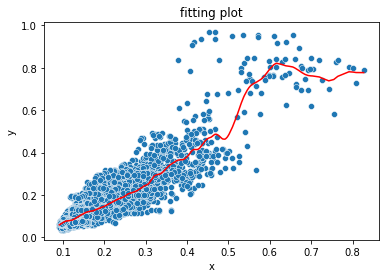

In [12]:
NCS.fit()